# Author: Mikita Sazanovich

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch

from classification.features import compute_kaldi_features, write_kaldi_descriptor, read_kaldi_features_to_tensor
from classification.features import compute_auto_features, build_merged_features
from classification.training import train_lstm, train_autoencoder

In [3]:
NUM_PEOPLE = 10

np.random.seed(7)

train_wav_paths = []
train_classes = []
test_wav_paths = []
test_classes = []
wav_dir = os.path.join('VCTK-Corpus', 'wav48')
persons = sorted(os.listdir(wav_dir))[:NUM_PEOPLE]
for num, person in enumerate(persons):
    person_dir = os.path.join(wav_dir, person)
    wav_names = list(map(lambda wav_name: os.path.join(person_dir, wav_name), os.listdir(person_dir)))
    train_person_speech, test_person_speech = train_test_split(wav_names, test_size=0.2)
    train_wav_paths.extend(train_person_speech)
    train_classes.extend([num] * len(train_person_speech))
    test_wav_paths.extend(test_person_speech)
    test_classes.extend([num] * len(test_person_speech))
print('train:', len(train_wav_paths), len(train_classes))
print('test:', len(test_wav_paths), len(test_classes))

train: 2966 2966
test: 749 749


In [4]:
train_desc_path = 'train_desc.scp'
test_desc_path = 'test_desc.scp'
write_kaldi_descriptor(train_wav_paths, train_desc_path)
write_kaldi_descriptor(test_wav_paths, test_desc_path)

In [5]:
train_kaldi_path = 'train_kaldi.ark'
test_kaldi_path = 'test_kaldi.ark'
compute_kaldi_features(train_desc_path, train_kaldi_path)
compute_kaldi_features(test_desc_path, test_kaldi_path)

Started processing train_desc.scp
Success! Result is written to train_kaldi.ark
Started processing test_desc.scp
Success! Result is written to test_kaldi.ark


In [6]:
train_features = read_kaldi_features_to_tensor(train_kaldi_path)
test_features = read_kaldi_features_to_tensor(test_kaldi_path)
print('Train:', len(train_features), len(train_classes))
print('Test:', len(test_features), len(test_classes))

Train: 2966 2966
Test: 749 749


In [7]:
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

GeForce GTX 1080 Ti


In [8]:
train_kaldi_losses, test_kaldi_accuracies = train_lstm(
    train_features, train_classes, test_features, test_classes, NUM_PEOPLE, device)

In [9]:
def smooth(scalars, weight=0.9):
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

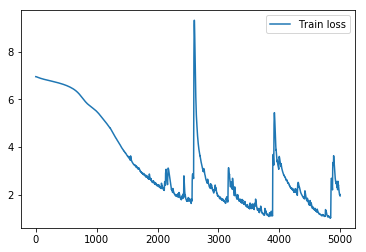

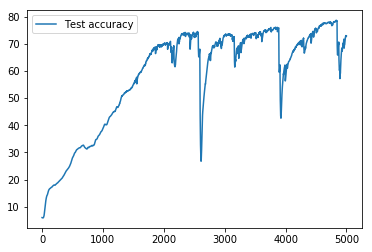

In [10]:
plt.plot(range(len(train_kaldi_losses)), smooth(train_kaldi_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_kaldi_accuracies)), smooth(test_kaldi_accuracies))
plt.legend(['Test accuracy'])
plt.show()

In [11]:
noised_wav_dir = os.path.join('VCTK-Corpus', 'noised')
assert os.path.exists(noised_wav_dir)
train_noised_paths = []
for train_wav_path in train_wav_paths:
    head, filename = os.path.split(train_wav_path)
    _, dirname = os.path.split(head)
    train_noised_path = os.path.join(noised_wav_dir, dirname, filename)
    assert os.path.exists(train_noised_path)
    train_noised_paths.append(train_noised_path)
train_noised_desc_path = 'train_noised_desc.scp'
write_kaldi_descriptor(train_noised_paths, train_noised_desc_path)

In [12]:
train_kaldi_noised_path = 'train_noised_kaldi.ark'
compute_kaldi_features(train_noised_desc_path, train_kaldi_noised_path)
train_noised_features = read_kaldi_features_to_tensor(train_kaldi_noised_path)

Started processing train_noised_desc.scp
Success! Result is written to train_noised_kaldi.ark


In [15]:
autoencoder, autoencoder_losses = train_autoencoder(train_noised_features, train_features, device)
autoencoder = autoencoder.cpu()

Total pairs for denoising: 1054069


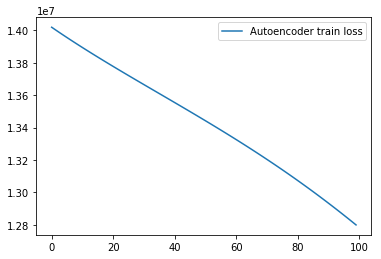

In [16]:
plt.plot(range(len(autoencoder_losses)), autoencoder_losses)
plt.legend(['Autoencoder train loss'])
plt.show()

In [17]:
train_auto_features = compute_auto_features(autoencoder, train_features)
test_auto_features = compute_auto_features(autoencoder, test_features)

In [18]:
train_auto_losses, test_auto_accuracies = train_lstm(
    train_auto_features, train_classes, test_auto_features, test_classes, NUM_PEOPLE, device)

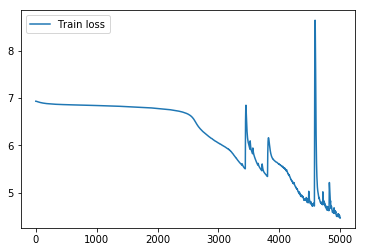

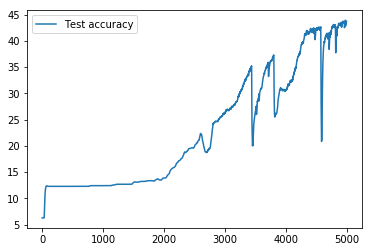

In [19]:
plt.plot(range(len(train_auto_losses)), smooth(train_auto_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_auto_accuracies)), smooth(test_auto_accuracies))
plt.legend(['Test accuracy'])
plt.show()

In [20]:
train_merged_features = build_merged_features(train_features, train_auto_features)
test_merged_features = build_merged_features(test_features, test_auto_features)

In [21]:
train_merged_losses, test_merged_accuracies = train_lstm(
    train_merged_features, train_classes, test_merged_features, test_classes, NUM_PEOPLE, device)

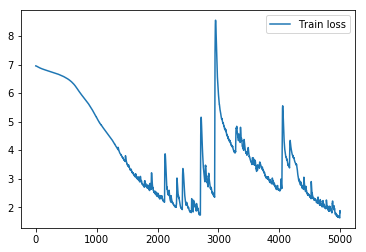

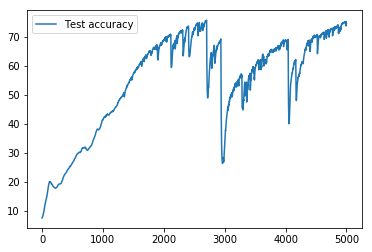

In [22]:
plt.plot(range(len(train_merged_losses)), smooth(train_merged_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_merged_accuracies)), smooth(test_merged_accuracies))
plt.legend(['Test accuracy'])
plt.show()

# Ablation study results

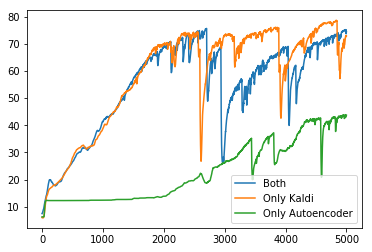

In [23]:
plt.plot(range(len(test_merged_accuracies)), smooth(test_merged_accuracies))
plt.plot(range(len(test_kaldi_accuracies)), smooth(test_kaldi_accuracies))
plt.plot(range(len(test_auto_accuracies)), smooth(test_auto_accuracies))
plt.legend(['Both', 'Only Kaldi', 'Only Autoencoder'])
plt.show()